# Projeto Neoway

## Stefanno Ruiz Manni

### Problema:
Você é um funcionário da OMS que deve avaliar os níveis de contaminação de um vírus em um
determinado país. As pessoas dentro de uma sociedade podem estar conectadas de alguma
maneira (familia, amizade ou trabalho) e cada pessoa possui um conjunto de atributos.

Este vírus afeta esta sociedade como descrito a seguir:

● a taxa de contaminação varia de pessoa para pessoa;

● a taxa de contaminação de uma pessoa A para B é diferente de B para A e depende
das características de ambas as pessoas (A e B);

● a contaminação só passa através de indivíduos conectados;

● não existe cura para essa doença;

### O desafio:
Foram coletados os dados de contaminação (ou seja, as taxas de contaminação) para metade
desta sociedade. Neste problema, você deverá estimar a taxa para o restante dessa sociedade
e decidir políticas de saúde com base nos resultados obtidos.
Observação: Para determinar as taxas de contaminação, devem ser levados em consideração
tanto as características dos infectados quanto dos infectantes.

# Pacotes

In [375]:
#Improrts
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.linear_model import ElasticNet
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import GradientBoostingRegressor
import math

In [376]:
#versoes utilizadas -- tambem encontrado em requirements.txt

# Versão da Linguagem Python
from platform import python_version
print('Python Version:', python_version())
print('Pandas Version:',pd.__version__)
print('Numpy Version:',np.__version__)
import matplotlib #importando matplot lib para verificacao da versao
print('Matplotlib Version', matplotlib.__version__)
print('Seaborn Version', sns.__version__)
import sklearn
print('Sklearn Version', sklearn.__version__)
print('Statsmodels Version', sklearn.__version__)
print('Math Version', sklearn.__version__)


Python Version: 3.7.10
Pandas Version: 1.3.0
Numpy Version: 1.20.3
Matplotlib Version 3.4.2
Seaborn Version 0.11.1
Sklearn Version 0.24.2
Statsmodels Version 0.24.2
Math Version 0.24.2


In [246]:
#importa modulo de funcoes
import funcoes

# Importando datasets

## Leitura das bases

In [247]:
#realizando a leitura dos arquivos

#define diretorio onde estao os arquivos
diretorio = r'C:\Users\stefanno.ruiz.manni\OneDrive - Accenture\Faculdade - Pessoal\ProjetoNeoway\Dados'

#define nome dos arquivos
file_name = 'individuos_espec.csv'
file_name2 = 'conexoes_espec.csv'

#realiza leitura dos arquivos
individuos = funcoes.importa_csv(diretorio,file_name,sep =';')
conexoes = funcoes.importa_csv(diretorio,file_name2,sep = ';')

In [248]:
individuos.shape

(1000000, 9)

In [249]:
conexoes.shape

(999999, 5)

In [250]:
#verifica se leitura deu certo
individuos.head()

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668


In [251]:
conexoes.head()

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN


## Juntando as duas bases

Adicionando os atributos dos individuos V1 e V2 na base de conexoes

In [252]:
#acrescentando informacoes sobre o individuo V1 na base de conexoes
df = conexoes.merge(individuos, left_on = 'V1', right_on = 'name', how='left')

In [253]:
#acrescentando informacoes sobre o individuo V2 na base de conexoes
df = df.merge(individuos, left_on = 'V2', right_on = 'name', how='left', suffixes = ('_V1','_V2'))

In [254]:
# Separando os dados a serem previstos e os dados coletados da populacao
df_to_predict = df[df.prob_V1_V2.isnull()]
df_populacao = df[df.prob_V1_V2.notnull()]

In [255]:
df_populacao.columns

Index(['V1', 'V2', 'grau', 'proximidade', 'prob_V1_V2', 'name_V1', 'idade_V1',
       'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1',
       'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1',
       'name_V2', 'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2',
       'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2',
       'IMC_V2'],
      dtype='object')

# Transformando variaveis categoricas em variaveis binarias

As colunas grau, proximidade, estado_civil e transporte_mais_utilizado sao variaveis categoricas e para facilitar futuras analises e processamentos vamos criar as variaveis binarias representando cada uma das categorias dentro dessas variaveis. Para os casos de nulos sera criado uma variavel binaria apontando que aquela informcao e nula. Dessa forma sera possivel utilizar essas variaveis para previsao da taxa de contaminacao para o restante da populacao.

Vamos criar tambem a variavel que junta grau e proximidade para termos essas duas informacoes em uma unica variavel e entender qual combinacao de grau e proximidade que impactam mais na taxa de contaminacao.

In [256]:
#concatena
df_populacao["grau_proximidade"] = df_populacao['grau'] + "_" + df_populacao['proximidade']
df_to_predict["grau_proximidade"] = df_to_predict['grau'] + "_" + df_to_predict['proximidade']

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [257]:
#define variaveis categoricas a serem binarizadas do individuo 1
cat_vars_V1 = ['transporte_mais_utilizado_V1','estado_civil_V1','proximidade','grau','grau_proximidade']

#define os prefixos das variaveis binarias do individuo1
prefixos_V1 = ['transporte_V1','estado_civil_V1','','g','gp']

#define variaveis categoricas a serem binzarizadas do individuo2
cat_vars_V2 = ['transporte_mais_utilizado_V2','estado_civil_V2']

#define os prefixos das variaveis binarias do individuo2
prefixos_V2 = ['trasnporte_V2','estado_civil_V2']

In [258]:
#criando variaveis dummies do individuo V1
df_populacao = funcoes.binarizar(df_populacao,cat_vars_V1,prefixos = prefixos_V1)
df_to_predict = funcoes.binarizar(df_to_predict,cat_vars_V1,prefixos = prefixos_V1)

#criando variaveis dummies do individuo V2
df_populacao = funcoes.binarizar(df_populacao,cat_vars_V2,prefixos = prefixos_V2)
df_to_predict = funcoes.binarizar(df_to_predict,cat_vars_V2,prefixos = prefixos_V2)

In [259]:
df_populacao.columns

Index(['V1', 'V2', 'grau', 'proximidade', 'prob_V1_V2', 'name_V1', 'idade_V1',
       'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1',
       'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1',
       'name_V2', 'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2',
       'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2',
       'IMC_V2', 'grau_proximidade', 'transporte_V1_particular',
       'transporte_V1_publico', 'transporte_V1_taxi', 'transporte_V1_nan',
       'estado_civil_V1_casado', 'estado_civil_V1_divorciado',
       'estado_civil_V1_solteiro', 'estado_civil_V1_viuvo',
       'estado_civil_V1_nan', '_mora_junto', '_visita_casual',
       '_visita_frequente', '_visita_rara', '_nan', 'g_amigos', 'g_familia',
       'g_trabalho', 'g_nan', 'gp_amigos_mora_junto',
       'gp_amigos_visita_casual', 'gp_amigos_visita_frequente',
       'gp_amigos_visita_rara', 'gp_familia_mora_junto',
       'gp_familia_visita_casual', 'gp_familia

In [260]:
df_to_predict.columns

Index(['V1', 'V2', 'grau', 'proximidade', 'prob_V1_V2', 'name_V1', 'idade_V1',
       'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1',
       'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1',
       'name_V2', 'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2',
       'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2',
       'IMC_V2', 'grau_proximidade', 'transporte_V1_particular',
       'transporte_V1_publico', 'transporte_V1_taxi', 'transporte_V1_nan',
       'estado_civil_V1_casado', 'estado_civil_V1_divorciado',
       'estado_civil_V1_solteiro', 'estado_civil_V1_viuvo',
       'estado_civil_V1_nan', '_mora_junto', '_visita_casual',
       '_visita_frequente', '_visita_rara', '_nan', 'g_amigos', 'g_familia',
       'g_trabalho', 'g_nan', 'gp_amigos_mora_junto',
       'gp_amigos_visita_casual', 'gp_amigos_visita_frequente',
       'gp_amigos_visita_rara', 'gp_familia_mora_junto',
       'gp_familia_visita_casual', 'gp_familia

# Analise Exploratoria dos Dados

## Entendendo a base de dados

### Verificando dados missing

In [262]:
#missing nos dados da populacao
df_populacao.isnull().sum()[0:30]

V1                                  0
V2                                  0
grau                                0
proximidade                         0
prob_V1_V2                          0
name_V1                             0
idade_V1                        48297
estado_civil_V1                 24991
qt_filhos_V1                    14528
estuda_V1                       19982
trabalha_V1                      3144
pratica_esportes_V1             74744
transporte_mais_utilizado_V1    21781
IMC_V1                          57138
name_V2                             0
idade_V2                        47724
estado_civil_V2                 25113
qt_filhos_V2                    14357
estuda_V2                       19979
trabalha_V2                      3222
pratica_esportes_V2             74543
transporte_mais_utilizado_V2    21647
IMC_V2                          56975
grau_proximidade                    0
transporte_V1_particular            0
transporte_V1_publico               0
transporte_V

In [263]:
#missing nos dados da populacao
df_populacao.isnull().sum()[31:]

estado_civil_V1_viuvo           0
estado_civil_V1_nan             0
_mora_junto                     0
_visita_casual                  0
_visita_frequente               0
_visita_rara                    0
_nan                            0
g_amigos                        0
g_familia                       0
g_trabalho                      0
g_nan                           0
gp_amigos_mora_junto            0
gp_amigos_visita_casual         0
gp_amigos_visita_frequente      0
gp_amigos_visita_rara           0
gp_familia_mora_junto           0
gp_familia_visita_casual        0
gp_familia_visita_frequente     0
gp_familia_visita_rara          0
gp_trabalho_mora_junto          0
gp_trabalho_visita_casual       0
gp_trabalho_visita_frequente    0
gp_trabalho_visita_rara         0
gp_nan                          0
trasnporte_V2_particular        0
trasnporte_V2_publico           0
trasnporte_V2_taxi              0
trasnporte_V2_nan               0
estado_civil_V2_casado          0
estado_civil_V

In [264]:
#missing nos dados a serem previstos (restante da populacao)
df_to_predict.isnull().sum()[0:30]

V1                                   0
V2                                   0
grau                                 0
proximidade                          0
prob_V1_V2                      500000
name_V1                              0
idade_V1                         47797
estado_civil_V1                  25037
qt_filhos_V1                     14612
estuda_V1                        20108
trabalha_V1                       3280
pratica_esportes_V1              74622
transporte_mais_utilizado_V1     21611
IMC_V1                           56958
name_V2                              0
idade_V2                         48213
estado_civil_V2                  24960
qt_filhos_V2                     14510
estuda_V2                        20151
trabalha_V2                       3131
pratica_esportes_V2              74581
transporte_mais_utilizado_V2     21386
IMC_V2                           56895
grau_proximidade                     0
transporte_V1_particular             0
transporte_V1_publico    

In [267]:
#missing nos dados a serem previstos (restante da populacao)
df_to_predict.isnull().sum()[31:]

estado_civil_V1_viuvo           0
estado_civil_V1_nan             0
_mora_junto                     0
_visita_casual                  0
_visita_frequente               0
_visita_rara                    0
_nan                            0
g_amigos                        0
g_familia                       0
g_trabalho                      0
g_nan                           0
gp_amigos_mora_junto            0
gp_amigos_visita_casual         0
gp_amigos_visita_frequente      0
gp_amigos_visita_rara           0
gp_familia_mora_junto           0
gp_familia_visita_casual        0
gp_familia_visita_frequente     0
gp_familia_visita_rara          0
gp_trabalho_mora_junto          0
gp_trabalho_visita_casual       0
gp_trabalho_visita_frequente    0
gp_trabalho_visita_rara         0
gp_nan                          0
trasnporte_V2_particular        0
trasnporte_V2_publico           0
trasnporte_V2_taxi              0
trasnporte_V2_nan               0
estado_civil_V2_casado          0
estado_civil_V

Verificamos a existencia de dados missing que deverão ser tratados para utilizarmos essas variaveis no modelo preditivo a ser construido. 

Poderíamos optar pela exclusão desses dados em nosso dataset, porém isso significaria uma impossibilidade da predição das taxas de transmissao para boa parte do restante da populacao caso essas variaveis entrem no modelo preditivo.

Para evitar essa perda será realizada a substituicao do dado missing pela moda no caso das variaveis binarias e pela media no caso das variaveis numericas.

### Describe das variaveis numericas

In [268]:
#descbrie das variaveis numericas
df_populacao.describe()

,V1,V2,prob_V1_V2,name_V1,idade_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,IMC_V1,...,gp_nan,trasnporte_V2_particular,trasnporte_V2_publico,trasnporte_V2_taxi,trasnporte_V2_nan,estado_civil_V2_casado,estado_civil_V2_divorciado,estado_civil_V2_solteiro,estado_civil_V2_viuvo,estado_civil_V2_nan
count,499999.000000,499999.000000,499999.000000,499999.000000,451702.000000,485471.000000,480017.000000,496855.000000,425255.000000,442861.000000,...,499999.0,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000
mean,250175.688027,500351.875552,0.485162,250175.688027,29.994983,0.928393,0.442378,0.557066,0.600252,22.459896,...,0.0,0.333899,0.574759,0.048048,0.043294,0.265707,0.176230,0.419753,0.088084,0.050226
std,144356.951435,288713.902933,0.173963,144356.951435,10.954417,0.997519,0.496669,0.496733,0.489847,7.081074,...,0.0,0.471604,0.494380,0.213868,0.203519,0.441709,0.381016,0.493519,0.283418,0.218411
min,1.000000,2.000000,0.074462,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.376728,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,125064.000000,250128.000000,0.351677,125064.000000,22.000000,0.000000,0.000000,0.000000,0.000000,17.416296,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,250466.000000,500932.000000,0.486413,250466.000000,29.000000,1.000000,0.000000,1.000000,1.000000,21.418552,...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,375183.500000,750368.000000,0.618210,375183.500000,37.000000,1.000000,1.000000,1.000000,1.000000,26.358214,...,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,499999.000000,999999.000000,0.942245,499999.000000,111.000000,8.000000,1.000000,1.000000,1.000000,89.158204,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [269]:
df_to_predict.describe()

,V1,V2,prob_V1_V2,name_V1,idade_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,IMC_V1,...,gp_nan,trasnporte_V2_particular,trasnporte_V2_publico,trasnporte_V2_taxi,trasnporte_V2_nan,estado_civil_V2_casado,estado_civil_V2_divorciado,estado_civil_V2_solteiro,estado_civil_V2_viuvo,estado_civil_V2_nan
count,500000.000000,500000.000000,0.0,500000.000000,452203.000000,485388.000000,479892.000000,496720.000000,425378.000000,443042.000000,...,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000
mean,249824.812324,499650.125150,NaN,249824.812324,30.025427,0.928927,0.443437,0.556162,0.599728,22.465314,...,0.0,0.334278,0.574798,0.048152,0.042772,0.264354,0.175876,0.421522,0.088328,0.04992
std,144317.967328,288635.934592,NaN,144317.967328,10.957007,0.997150,0.496791,0.496836,0.489954,7.073234,...,0.0,0.471738,0.494374,0.214088,0.202343,0.440989,0.380715,0.493803,0.283772,0.21778
min,2.000000,4.000000,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.376728,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,124949.750000,249899.750000,NaN,124949.750000,22.000000,0.000000,0.000000,0.000000,0.000000,17.411286,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,249556.500000,499113.500000,NaN,249556.500000,29.000000,1.000000,0.000000,1.000000,1.000000,21.414840,...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,374810.000000,749620.250000,NaN,374810.000000,37.000000,1.000000,1.000000,1.000000,1.000000,26.381444,...,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000
max,500000.000000,1000000.000000,NaN,500000.000000,111.000000,8.000000,1.000000,1.000000,1.000000,84.681985,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [270]:
#describe de quem pratica esporte
df_populacao[df_populacao['pratica_esportes_V1']==1].describe()

,V1,V2,prob_V1_V2,name_V1,idade_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,IMC_V1,...,gp_nan,trasnporte_V2_particular,trasnporte_V2_publico,trasnporte_V2_taxi,trasnporte_V2_nan,estado_civil_V2_casado,estado_civil_V2_divorciado,estado_civil_V2_solteiro,estado_civil_V2_viuvo,estado_civil_V2_nan
count,255260.000000,255260.000000,255260.000000,255260.000000,230501.000000,247751.000000,244965.000000,253641.000000,255260.0,225863.000000,...,255260.0,255260.000000,255260.000000,255260.000000,255260.000000,255260.000000,255260.000000,255260.000000,255260.000000,255260.000000
mean,250144.366266,500289.232273,0.534798,250144.366266,30.009301,0.929034,0.441843,0.558364,1.0,22.459838,...,0.0,0.334819,0.573165,0.048308,0.043708,0.265126,0.176232,0.419862,0.088337,0.050443
std,144484.827223,288969.654655,0.164574,144484.827223,10.956142,0.998773,0.496607,0.496583,0.0,7.077839,...,0.0,0.471928,0.494619,0.214416,0.204446,0.441401,0.381018,0.493537,0.283785,0.218857
min,1.000000,2.000000,0.121415,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,5.710526,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,124835.500000,249671.750000,0.415466,124835.500000,22.000000,0.000000,0.000000,0.000000,1.0,17.434783,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,250357.500000,500715.500000,0.538759,250357.500000,29.000000,1.000000,0.000000,1.000000,1.0,21.417416,...,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,374964.750000,749930.250000,0.661121,374964.750000,37.000000,1.000000,1.000000,1.000000,1.0,26.335078,...,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,499993.000000,999987.000000,0.942245,499993.000000,110.000000,8.000000,1.000000,1.000000,1.0,80.099185,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [271]:
#taxa media de contaminacao pro grau de relacionamento
df_grau_grupo = df_populacao.groupby('grau').agg({'prob_V1_V2' : 'mean'}).reset_index().rename(
    columns = {'prob_V1_V2' : 'Media_Tx_Contaminacao'})

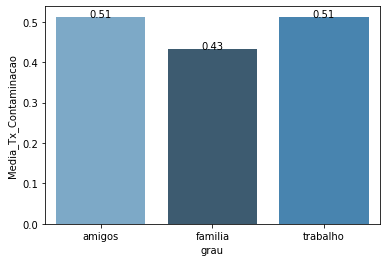

In [272]:
pal = sns.color_palette("Blues_d", len(df_grau_grupo))
rank = df_grau_grupo["Media_Tx_Contaminacao"].argsort().argsort() 
g=sns.barplot(x='grau',y='Media_Tx_Contaminacao',data=df_grau_grupo, palette=np.array(pal[::-1])[rank])

for index, row in df_grau_grupo.iterrows():
    g.text(row.name, row.Media_Tx_Contaminacao,round(row.Media_Tx_Contaminacao,2), color='black', ha="center")

plt.show()

<AxesSubplot:xlabel='Media_Tx_Contaminacao', ylabel='grau_proximidade'>

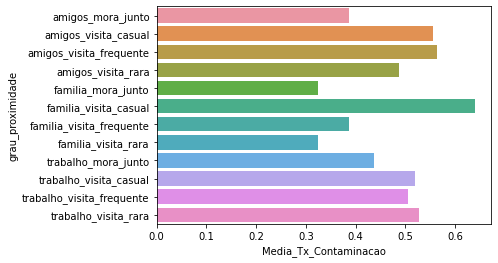

In [273]:
#taxa media de contaminacao por grau_proximidade
df_graup_grupo = df_populacao.groupby('grau_proximidade').agg({'prob_V1_V2' : 'mean'}).reset_index().rename(
    columns = {'prob_V1_V2' : 'Media_Tx_Contaminacao'})

sns.barplot(data=df_graup_grupo, y = 'grau_proximidade', x = 'Media_Tx_Contaminacao')

In [274]:
#taxa media de contaminacao por idade do individuo V1

#cria faixas de idade
df_idade = df_populacao[['prob_V1_V2','idade_V1']]

bins= [0,18,30,45,60,130]
labels = ['0_18anos','19_30anos','31_45anos','46_60anos','60anos+']
df_idade['faixa_idade'] = pd.cut(df_idade['idade_V1'], bins=bins, labels=labels, right=False)

df_idade_grupo = df_idade.groupby('faixa_idade').agg({'prob_V1_V2' : 'mean',
                                                     'idade_V1':'count'}).reset_index().rename(
    columns = {'prob_V1_V2' : 'Media_Tx_Contaminacao'})


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


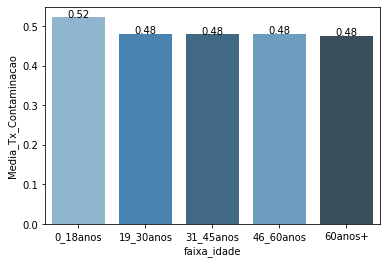

In [275]:
pal = sns.color_palette("Blues_d", len(df_idade_grupo))
rank = df_idade_grupo["Media_Tx_Contaminacao"].argsort().argsort() 
g=sns.barplot(x='faixa_idade',y='Media_Tx_Contaminacao',data=df_idade_grupo, palette=np.array(pal[::-1])[rank])

for index, row in df_idade_grupo.iterrows():
    g.text(row.name, row.Media_Tx_Contaminacao,round(row.Media_Tx_Contaminacao,2), color='black', ha="center")

plt.show()

## Analise de correlacao

In [276]:
#seta colunas para analise de correlacao
vars_corr = ['prob_V1_V2','g_amigos','g_familia','g_trabalho','idade_V1','qt_filhos_V1','estuda_V1','pratica_esportes_V1','IMC_V1','idade_V2','qt_filhos_V2','estuda_V2',
             'pratica_esportes_V2','IMC_V2','transporte_V1_particular',
             'transporte_V1_publico','transporte_V1_taxi','transporte_V1_nan', 'estado_civil_V1_casado',
             'estado_civil_V1_divorciado','estado_civil_V1_solteiro','estado_civil_V1_viuvo','estado_civil_V1_nan',
             '_mora_junto','_visita_casual','_visita_frequente','_visita_rara','trasnporte_V2_particular',
             'trasnporte_V2_publico','trasnporte_V2_taxi','trasnporte_V2_nan','estado_civil_V2_casado',
             'estado_civil_V2_divorciado','estado_civil_V2_solteiro','estado_civil_V2_viuvo','estado_civil_V2_nan']

vars_corr_reduced = ['prob_V1_V2','g_amigos','g_familia','g_trabalho','idade_V1','pratica_esportes_V1',
             'transporte_V1_particular','transporte_V1_publico','transporte_V1_taxi','transporte_V1_nan', 'estado_civil_V1_casado',
             'estado_civil_V1_divorciado','estado_civil_V1_solteiro','estado_civil_V1_viuvo',
             '_mora_junto','_visita_casual','_visita_frequente','_visita_rara','trasnporte_V2_particular',
             'trasnporte_V2_publico','gp_amigos_visita_casual', 'gp_amigos_visita_frequente',
       'gp_amigos_visita_rara', 'gp_familia_mora_junto',
       'gp_familia_visita_casual', 'gp_familia_visita_frequente',
       'gp_familia_visita_rara', 'gp_trabalho_mora_junto',
       'gp_trabalho_visita_casual', 'gp_trabalho_visita_frequente',
       'gp_trabalho_visita_rara']

In [277]:
corr = df_populacao[vars_corr_reduced].corr()

In [280]:
corr = corr.iloc[0:,0:1]

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

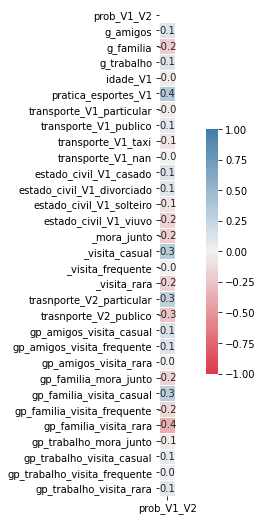

In [281]:
#analise de correlacao reduzida, apenas vendo correlacao com a variavel resposta
#mascara
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#configura area de plotagem
f, ax = plt.subplots(figsize=(11,9))

#definindo mapa de cores
cmap = sns.diverging_palette(10,240, as_cmap=True)

#desenhando o mapa de calor das correlacoes
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1, annot=True, square=True,fmt='.1f', linewidths=.5, cbar_kws={"shrink": .5})


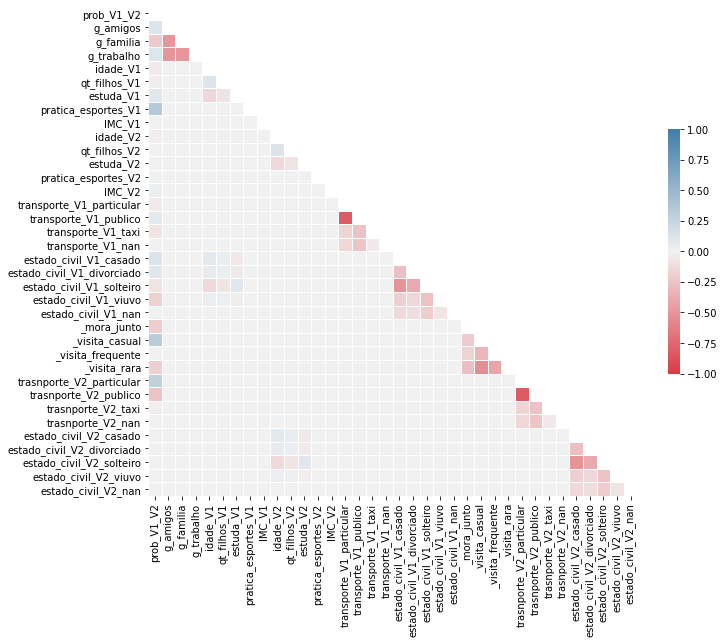

In [130]:
funcoes.corr_plot(df_populacao,vars_corr, annot=False)

A analise de correlacao acima nos mostra que as variaveis que possuem maior correlacao (positiva) sobre a taxa de transmissao entre dois individuos é a pratica de esportes pelo individuo doente (V1) e a proximidade de visita casual, alem de grau de trabalho e amizade. Ja a utilizacao de transporte publico, porximidade de visita rara e grau de familia estao correlacionados negativamente com a taxa de transmissao entre dois individuos.

As demais variaveis possuem baixas correlacoes com a taxa de transmissao e também possuem baixa correlacao entre si (exceto pelas variaveis binarias das variaveis categoricas), o que aponta que não temos problemas de multicolinearidade nas variaveis explicativas.

As variaveis que possuem alta correlacao entre si sao variaveis binarias de uma mesma categoria, assim quando essas variaveis forem utilizadas no modelo, uma das categorias deve ser exlcuida.

### Plots de distribuicao das variaveis

In [282]:
num_vars = ['prob_V1_V2','idade_V1','qt_filhos_V1','estuda_V1','pratica_esportes_V1','IMC_V1','idade_V2','qt_filhos_V2','estuda_V2',
             'pratica_esportes_V2','IMC_V2']

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


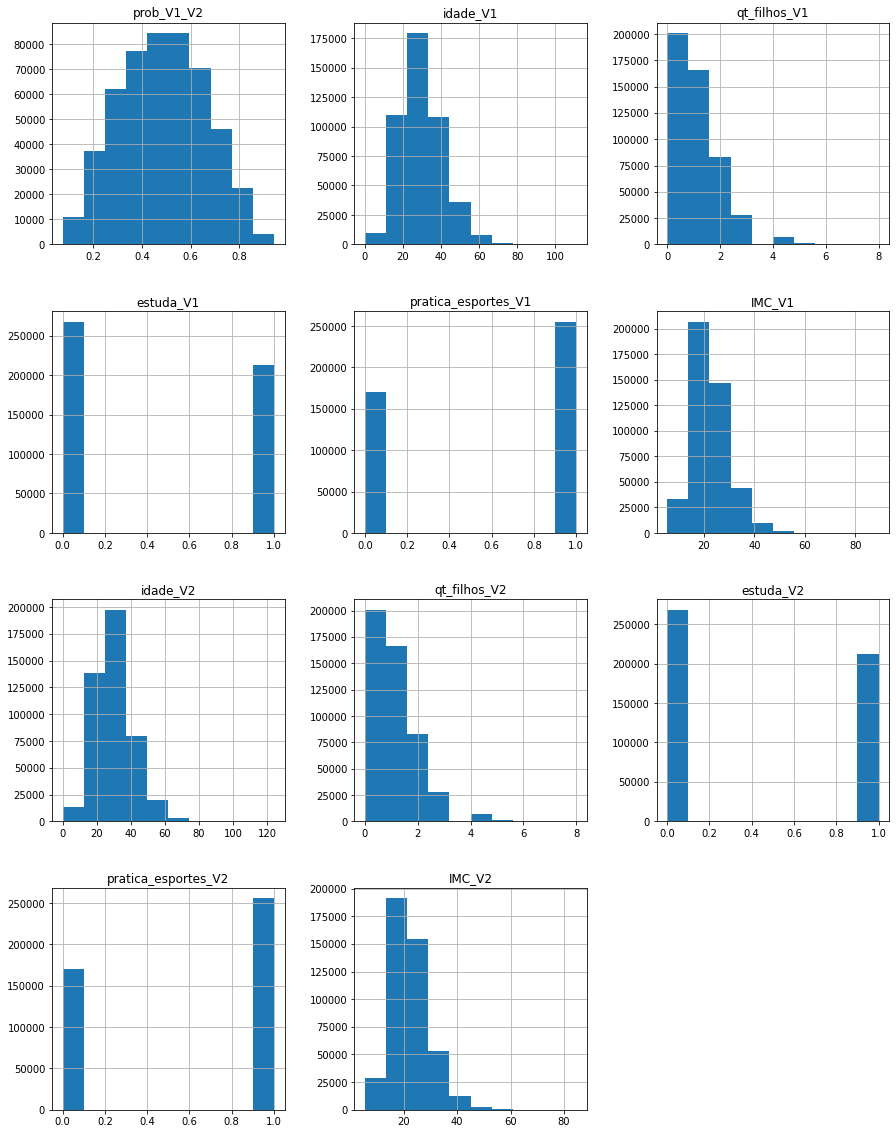

In [283]:
# Histograma Univariado das variaveis numericas
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_populacao[num_vars].hist(ax = ax)
plt.show()

## barplot das variaveis categoricas

In [284]:
#agrupa tabela por categorias

#tabela agrupada de transporte mais utilizado
df_transporte_grupo = df_populacao.groupby('transporte_mais_utilizado_V1').agg({'V1' : 'count'}).reset_index().rename(
    columns = {'V1' : 'individuos',
               'transporte_mais_utilizado_V1' : 'transporte'})
#tabela agrupada de proximidade
df_proximidade_grupo = df_populacao.groupby('proximidade').agg({'V1' : 'count'}).reset_index().rename(
    columns = {'V1' : 'relacoes'})

df_ecivil_grupo = df_populacao.groupby('estado_civil_V1').agg({'V1' : 'count'}).reset_index().rename(
    columns = {'V1' : 'individuos',
               'estado_civil_V1' : 'estado_civil'})

df_grau_grupo = df_populacao.groupby('grau').agg({'V1' : 'count'}).reset_index().rename(
    columns = {'V1' : 'relacoes',
               'grau' : 'grau_relacionamento'})

In [285]:
df_proximidade_grupo

,proximidade,relacoes
0,mora_junto,49891
1,visita_casual,150365
2,visita_frequente,99452
3,visita_rara,200291


<AxesSubplot:xlabel='transporte', ylabel='individuos'>

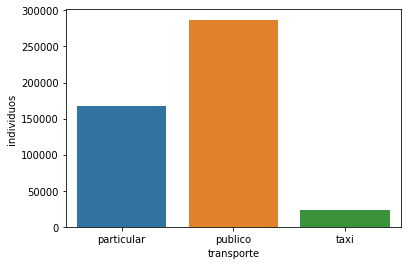

In [286]:
sns.barplot(data=df_transporte_grupo, y = 'individuos', x = 'transporte')

<AxesSubplot:xlabel='proximidade', ylabel='relacoes'>

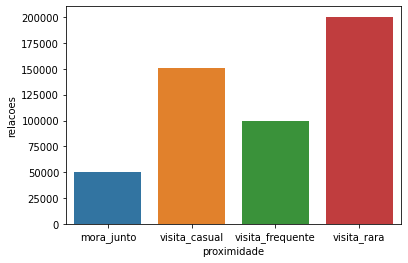

In [287]:
sns.barplot(data=df_proximidade_grupo, y = 'relacoes', x = 'proximidade')


<AxesSubplot:xlabel='estado_civil', ylabel='individuos'>

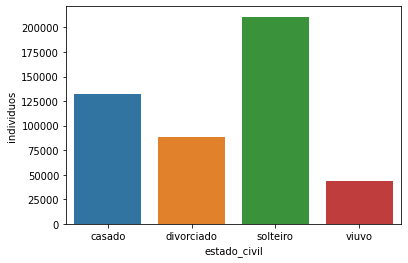

In [288]:
sns.barplot(data=df_ecivil_grupo, y = 'individuos', x = 'estado_civil')

<AxesSubplot:xlabel='grau_relacionamento', ylabel='relacoes'>

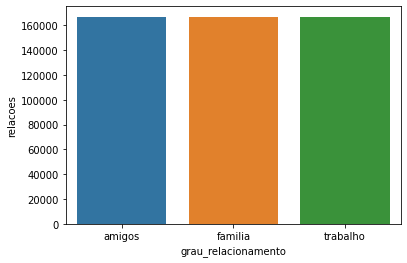

In [289]:
sns.barplot(data=df_grau_grupo, y = 'relacoes', x = 'grau_relacionamento')

# Tratamento dos dados

## Tratando os dados missing

Como visto anteriormente os dados missing precisam ser tratados. As variaveis binarias terao os missing substituidos pela moda, ja as variaveis numericas pela media.

In [290]:
#trata variaveis binarias pela moda
bin_vars= ['pratica_esportes_V1','pratica_esportes_V2','trabalha_V1','trabalha_V2','estuda_V1','estuda_V2']

#trata dados da populacao conhecida
funcoes.trata_missing(df_populacao,vars=bin_vars,tipo='moda')

#trata dados da populacao a ter a taxa estimada
funcoes.trata_missing(df_to_predict,vars=bin_vars,tipo='moda')

substituindo pela moda
tratando pratica_esportes_V1
tratando pratica_esportes_V2
tratando trabalha_V1
tratando trabalha_V2
tratando estuda_V1
tratando estuda_V2
substituindo pela moda
tratando pratica_esportes_V1
tratando pratica_esportes_V2
tratando trabalha_V1
tratando trabalha_V2
tratando estuda_V1
tratando estuda_V2


In [291]:
#trata variaveis numericas pela media
num_vars = ['idade_V1','qt_filhos_V1','IMC_V1','idade_V2','qt_filhos_V2','IMC_V2']

#trata dados da populacao conhecida
funcoes.trata_missing(df_populacao,vars=num_vars,tipo='media')

#trata dados da populacao a ter a taxa estimada
funcoes.trata_missing(df_to_predict,vars=num_vars,tipo='media')

substituindo pela media
tratando: idade_V1
tratando: qt_filhos_V1
tratando: IMC_V1
tratando: idade_V2
tratando: qt_filhos_V2
tratando: IMC_V2
substituindo pela media
tratando: idade_V1
tratando: qt_filhos_V1
tratando: IMC_V1
tratando: idade_V2
tratando: qt_filhos_V2
tratando: IMC_V2


In [292]:
#dropando variaveis que nao serao utilizadas (variaveis categoricas que ja foram binarizadas)
dropa = ['estado_civil_V1','transporte_mais_utilizado_V1','estado_civil_V2','transporte_mais_utilizado_V2','_nan']

df_populacao.drop(dropa,axis = 1, inplace=True)
df_to_predict.drop(dropa,axis = 1, inplace=True)

In [293]:
#check nulos
df_populacao.isnull().sum()

V1                              0
V2                              0
grau                            0
proximidade                     0
prob_V1_V2                      0
name_V1                         0
idade_V1                        0
qt_filhos_V1                    0
estuda_V1                       0
trabalha_V1                     0
pratica_esportes_V1             0
IMC_V1                          0
name_V2                         0
idade_V2                        0
qt_filhos_V2                    0
estuda_V2                       0
trabalha_V2                     0
pratica_esportes_V2             0
IMC_V2                          0
grau_proximidade                0
transporte_V1_particular        0
transporte_V1_publico           0
transporte_V1_taxi              0
transporte_V1_nan               0
estado_civil_V1_casado          0
estado_civil_V1_divorciado      0
estado_civil_V1_solteiro        0
estado_civil_V1_viuvo           0
estado_civil_V1_nan             0
_mora_junto   

In [294]:
#check nulos
df_to_predict.isnull().sum()

V1                                   0
V2                                   0
grau                                 0
proximidade                          0
prob_V1_V2                      500000
name_V1                              0
idade_V1                             0
qt_filhos_V1                         0
estuda_V1                            0
trabalha_V1                          0
pratica_esportes_V1                  0
IMC_V1                               0
name_V2                              0
idade_V2                             0
qt_filhos_V2                         0
estuda_V2                            0
trabalha_V2                          0
pratica_esportes_V2                  0
IMC_V2                               0
grau_proximidade                     0
transporte_V1_particular             0
transporte_V1_publico                0
transporte_V1_taxi                   0
transporte_V1_nan                    0
estado_civil_V1_casado               0
estado_civil_V1_divorciad

## Normalizando os dados

Para problemas de regressao a normalizacao das variaveis pode ser um passo importante a depender da tecnica a ser utilizada para que uma variavel nao predomine sobre a outra.

Nesse projeto vamos aplicar o MinMaxScaler para colocar todas as variaveis numericas nao binarias na mesma escala entre 0 e 1. O MinMax sera treinado nos dados da populacao e aplicado na populacao a ser predita.

Para alguns algoritmos esse passo pode ser desnecessario.

In [295]:
vars_norm = ['idade_V1','idade_V2','qt_filhos_V1','qt_filhos_V2','IMC_V1','IMC_V2']

In [296]:
#gerando o scaler
scaler = MinMaxScaler()

#dando fit no scaler
scaler.fit(df_populacao[vars_norm])

#normalizando variaveis no dataset da populacao
df_populacao[vars_norm] = scaler.fit_transform(df_populacao[vars_norm])

#normalizando as variaveis do restante da populacao (a ser predita), 
#utilizando o scaler dos dados da populacao (que serao usado no treino do modelo)
df_to_predict[vars_norm] = scaler.transform(df_to_predict[vars_norm])

In [297]:
df_to_predict[vars_norm].head()

,idade_V1,idade_V2,qt_filhos_V1,qt_filhos_V2,IMC_V1,IMC_V2
2,0.216216,0.403226,0.000,0.125,0.238740,0.268115
4,0.315315,0.161290,0.125,0.125,0.173972,0.188187
6,0.450450,0.403226,0.125,0.000,0.254893,0.201249
9,0.270270,0.169355,0.250,0.000,0.118391,0.238311
10,0.180180,0.338710,0.125,0.125,0.179469,0.214185


In [298]:
df_populacao[vars_norm].head()

,idade_V1,idade_V2,qt_filhos_V1,qt_filhos_V2,IMC_V1,IMC_V2
0,0.396396,0.193548,0.125,0.000,0.200811,0.250997
1,0.396396,0.282258,0.125,0.125,0.200811,0.182362
3,0.216216,0.241935,0.000,0.250,0.238740,0.123461
5,0.315315,0.443548,0.125,0.125,0.173972,0.214279
7,0.450450,0.338710,0.125,0.125,0.254893,0.445970


# Feature Selection

In [299]:
#realizando lasso para selecao de variaveis

#definindo X e Y

Y_lasso = df_populacao.filter(['prob_V1_V2'])

#x contendo todas as variaveis e excluindo as dummies redundantes (estado_civil_solteiro, tranporte_publico e visita rara)
X_lasso = df_populacao.filter(['idade_V1','qt_filhos_V1','estuda_V1','pratica_esportes_V1','IMC_V1','idade_V2','qt_filhos_V2','estuda_V2',
             'pratica_esportes_V2','IMC_V2','transporte_V1_particular',
             'transporte_V1_publico','transporte_V1_taxi','transporte_V1_nan', 'estado_civil_V1_casado',
             'estado_civil_V1_divorciado','estado_civil_V1_solteiro','estado_civil_V1_viuvo','estado_civil_V1_nan',
             '_mora_junto','_visita_casual','_visita_frequente','_visita_rara','trasnporte_V2_particular',
             'trasnporte_V2_publico','trasnporte_V2_taxi','trasnporte_V2_nan','estado_civil_V2_casado',
             'estado_civil_V2_divorciado','estado_civil_V2_solteiro','estado_civil_V2_viuvo','estado_civil_V2_nan','gp_amigos_visita_casual', 'gp_amigos_visita_frequente',
       'gp_amigos_visita_rara', 'gp_familia_mora_junto',
       'gp_familia_visita_casual', 'gp_familia_visita_frequente',
       'gp_familia_visita_rara', 'gp_trabalho_mora_junto',
       'gp_trabalho_visita_casual', 'gp_trabalho_visita_frequente',
       'gp_trabalho_visita_rara'])



In [300]:
#cria modelo
selecao_lasso = Lasso(alpha=0.0005)

In [301]:
#fit do modelo
selecao_lasso.fit(X_lasso,Y_lasso)

Lasso(alpha=0.0005)

In [302]:
coeficientes = pd.DataFrame({'var' : X_lasso.columns,'coef':selecao_lasso.coef_})
print(coeficientes[coeficientes.coef != 0])

                             var          coef
0                       idade_V1 -2.450436e-02
2                      estuda_V1  3.084000e-02
3            pratica_esportes_V1  1.105659e-01
11         transporte_V1_publico  1.775163e-02
12            transporte_V1_taxi -3.939510e-02
14        estado_civil_V1_casado  3.509953e-02
15    estado_civil_V1_divorciado  3.592823e-02
16      estado_civil_V1_solteiro -1.664055e-02
17         estado_civil_V1_viuvo -9.238012e-02
19                   _mora_junto -9.009750e-02
20                _visita_casual  5.710730e-02
22                  _visita_rara -1.815751e-03
23      trasnporte_V2_particular  7.456570e-02
24         trasnporte_V2_publico -2.834602e-02
32       gp_amigos_visita_casual  6.371771e-04
33    gp_amigos_visita_frequente  6.326522e-02
34         gp_amigos_visita_rara -1.446522e-08
35         gp_familia_mora_junto -6.334766e-02
36      gp_familia_visita_casual  8.662029e-02
37   gp_familia_visita_frequente -9.891692e-02
38        gp_

In [303]:
print(coeficientes)

                             var          coef
0                       idade_V1 -2.450436e-02
1                   qt_filhos_V1 -0.000000e+00
2                      estuda_V1  3.084000e-02
3            pratica_esportes_V1  1.105659e-01
4                         IMC_V1  0.000000e+00
5                       idade_V2 -0.000000e+00
6                   qt_filhos_V2 -0.000000e+00
7                      estuda_V2  0.000000e+00
8            pratica_esportes_V2 -0.000000e+00
9                         IMC_V2  0.000000e+00
10      transporte_V1_particular -0.000000e+00
11         transporte_V1_publico  1.775163e-02
12            transporte_V1_taxi -3.939510e-02
13             transporte_V1_nan  0.000000e+00
14        estado_civil_V1_casado  3.509953e-02
15    estado_civil_V1_divorciado  3.592823e-02
16      estado_civil_V1_solteiro -1.664055e-02
17         estado_civil_V1_viuvo -9.238012e-02
18           estado_civil_V1_nan  0.000000e+00
19                   _mora_junto -9.009750e-02
20           

Com base no metodo de regressao lasso podemos utiliza-lo para selecionar quais variaveis deveriam entrar no modelo. A regressao lasso ao tentar minimizar a funcao de custo seleciona quais variaveis sao importantes, zerando o coeficiente das variaveis nao relevantes.

Utilizando o resultado da analise acima podemos concluir que a maior parte das variaveis relacionadas ao individuo saudavel nao sao relevantes para o modelo. Para a criacao do nosso modelo base utilizaremos as variaveis em que os coeficientes nao foram zerados

# Criando modelo Base linear

## Selecionando as variaveis do lasso

In [304]:
coeficientes = coeficientes[coeficientes.coef!=0]

In [305]:
vars_selected = coeficientes['var'].tolist()
vars_selected

['idade_V1',
 'estuda_V1',
 'pratica_esportes_V1',
 'transporte_V1_publico',
 'transporte_V1_taxi',
 'estado_civil_V1_casado',
 'estado_civil_V1_divorciado',
 'estado_civil_V1_solteiro',
 'estado_civil_V1_viuvo',
 '_mora_junto',
 '_visita_casual',
 '_visita_rara',
 'trasnporte_V2_particular',
 'trasnporte_V2_publico',
 'gp_amigos_visita_casual',
 'gp_amigos_visita_frequente',
 'gp_amigos_visita_rara',
 'gp_familia_mora_junto',
 'gp_familia_visita_casual',
 'gp_familia_visita_frequente',
 'gp_familia_visita_rara',
 'gp_trabalho_mora_junto',
 'gp_trabalho_visita_casual',
 'gp_trabalho_visita_frequente',
 'gp_trabalho_visita_rara']

In [393]:
#tira variaveis selecionadas extremamente correlacionados --> tranposrte publico e particular e casado e divorciado
#vou manter apenas transporte particular e casado
vars_selected_manual=[
'idade_V1',
'estuda_V1',
'pratica_esportes_V1',
'transporte_V1_publico',
'transporte_V1_taxi',
'estado_civil_V1_casado',
'estado_civil_V1_solteiro',
'estado_civil_V1_viuvo',
#'_mora_junto',
#'_visita_casual',
#'_visita_rara',
'trasnporte_V2_particular',
'gp_amigos_visita_casual',
'gp_amigos_visita_frequente',
'gp_amigos_visita_rara',
'gp_familia_mora_junto',
'gp_familia_visita_casual',
'gp_familia_visita_frequente',
'gp_familia_visita_rara',
'gp_trabalho_mora_junto',
'gp_trabalho_visita_casual',
'gp_trabalho_visita_frequente',
'gp_trabalho_visita_rara']

## Cross validation do modelo linear
Realizando o cross validation do modelo lienar para determinar baselines de comparacao

In [394]:

#definindo X e Y

Y = df_populacao.filter(['prob_V1_V2'])

#x 
X = df_populacao.filter(vars_selected_manual)



# Definindo os valores para o número de folds
num_folds = 5
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, shuffle = True, random_state = seed)

# Criando o modelo
modelo = LinearRegression()

# Cross Validation
resultado_rmse = cross_validate(modelo, X, Y, cv = kfold, scoring = 'neg_root_mean_squared_error', return_train_score = True)
resultado_r2 = cross_validate(modelo, X, Y, cv = kfold, scoring = 'r2', return_train_score = True)
resultado_rmse

{'fit_time': array([0.51362753, 0.51861477, 0.50066257, 0.48370814, 0.55551648]),
 'score_time': array([0.02393508, 0.01695609, 0.02094603, 0.01695371, 0.01795125]),
 'test_score': array([-0.11849147, -0.1182909 , -0.11783772, -0.11804355, -0.11772963]),
 'train_score': array([-0.11797092, -0.1180207 , -0.11813431, -0.11808288, -0.11816085])}

In [395]:
-resultado_rmse['test_score'].mean()

0.11807865482564472

In [396]:
resultado_r2['test_score'].mean()

0.539276976231443

## Criacao do modelo base

In [397]:
#separa em dados de treino e teste para plotar os residuos
seed=7

X_treino,X_teste,Y_treino,Y_teste = train_test_split(X,Y, test_size = 0.2, random_state = seed)

# Criação do modelo
modelo = LinearRegression()

# Treinamento do modelo
modelo.fit(X_treino, Y_treino)

# Score do modelo nos dados de teste
result = modelo.predict(X_teste)

df_result = pd.DataFrame(data= result.flatten(), columns =['Previsto'])
df_result['Actual'] = Y_teste.values
df_result['Residuo'] = df_result.Actual - df_result.Previsto
df_result['IdadeV1'] = X_teste.idade_V1.values

<AxesSubplot:>

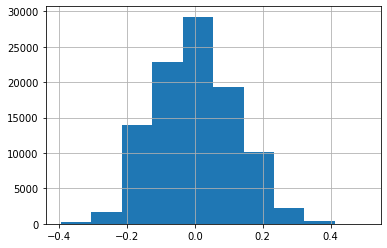

In [398]:
#histograma dos residuos
df_result.Residuo.hist()

<AxesSubplot:xlabel='Previsto', ylabel='Residuo'>

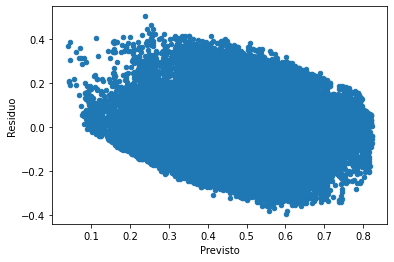

In [399]:
#Residuo vs fitted
df_result.plot(kind='scatter', y='Residuo', x='Previsto')

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


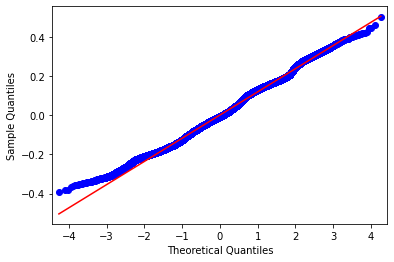

In [400]:
qqplot(df_result.Residuo, line='s')
plt.show()

O primeiro modelo base construido possui um baixo R2, o que mostra um baixo pode explicativo do modelo. Assim sera criado novos modelos com novos algoritmos afim de aumentar o poder explicativo do modelo e inferir a influencia das variaveis explicativas na taxa de transmissao do virus.

Alem disso temos o RMSE medio nos folds de 0.02, o que nos da um baseline para a medida da raiz quadrada do erro medio

A analise dos residuos nos mostram que os erros possuem uma distribuicao normal (Q-Q plot e histograma dos residuos), porem ao olharmos o residuo em relacao ao previsto percebemos que o modelo tende a errar para cima nas menores taxas de transmissao

# Modelo com GradientBoosting

In [401]:
#definindo X e Y

Y = df_populacao.filter(['prob_V1_V2']).values

#x contendo todas as variaveis e excluindo as dummies redundantes (estado_civil_solteiro, tranporte_publico e visita rara)
X = df_populacao.filter(vars_selected_manual).values


# Definindo os valores para o número de folds
num_folds = 5
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, shuffle = True, random_state = seed)

# Criando o modelo
modelo = GradientBoostingRegressor(random_state=0, criterion = 'mse', verbose = True)

# Cross Validation
resultado_rmse = cross_validate(modelo, X, Y, cv = kfold, scoring = 'neg_root_mean_squared_error', return_train_score = True)
resultado_r2 = cross_validate(modelo, X, Y, cv = kfold, scoring = 'r2', return_train_score = True)
resultado_rmse

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.22m
         2           0.0270            1.14m
         3           0.0258            1.07m
         4           0.0248            1.05m
         5           0.0240            1.10m
         6           0.0232            1.19m
         7           0.0225            1.21m
         8           0.0219            1.22m
         9           0.0214            1.18m
        10           0.0209            1.15m
        20           0.0164           59.08s
        30           0.0138           50.13s
        40           0.0124           44.21s
        50           0.0115           37.38s
        60           0.0107           30.84s
        70           0.0104           22.95s
        80           0.0102           15.47s
        90           0.0099            7.85s
       100           0.0097            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.16m
         2           0.0270            1.13m
         3           0.0258            1.09m
         4           0.0248            1.11m
         5           0.0239            1.08m
         6           0.0232            1.07m
         7           0.0225            1.11m
         8           0.0219            1.21m
         9           0.0214            1.19m
        10           0.0209            1.20m
        20           0.0170            1.09m
        30           0.0139           54.52s
        40           0.0125           46.48s
        50           0.0116           37.58s
        60           0.0109           29.08s
        70           0.0106           21.94s
        80           0.0103           14.46s
        90           0.0100            7.24s
       100           0.0099            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.09m
         2           0.0270            1.05m
         3           0.0258            1.06m
         4           0.0248            1.02m
         5           0.0240            1.00m
         6           0.0232            1.04m
         7           0.0225            1.02m
         8           0.0219           59.64s
         9           0.0214           58.19s
        10           0.0209           57.00s
        20           0.0164           49.01s
        30           0.0140           42.32s
        40           0.0129           36.02s
        50           0.0120           30.02s
        60           0.0116           23.98s
        70           0.0112           18.19s
        80           0.0107           12.12s
        90           0.0104            6.04s
       100           0.0101            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285           57.56s
         2           0.0271           58.64s
         3           0.0259           57.43s
         4           0.0248           57.04s
         5           0.0240           56.83s
         6           0.0232           59.33s
         7           0.0225           57.93s
         8           0.0219           57.54s
         9           0.0214           58.94s
        10           0.0209           59.85s
        20           0.0170           51.73s
        30           0.0147           43.83s
        40           0.0128           37.13s
        50           0.0121           30.65s
        60           0.0114           24.98s
        70           0.0110           18.91s
        80           0.0108           12.82s
        90           0.0104            6.38s
       100           0.0102            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.13m
         2           0.0271            1.04m
         3           0.0259            1.01m
         4           0.0248           58.74s
         5           0.0240           59.67s
         6           0.0232           58.20s
         7           0.0225           56.88s
         8           0.0219           55.78s
         9           0.0214           54.75s
        10           0.0209           53.95s
        20           0.0165           47.30s
        30           0.0142           41.32s
        40           0.0131           35.49s
        50           0.0121           29.56s
        60           0.0111           23.62s
        70           0.0106           17.98s
        80           0.0103           12.21s
        90           0.0101            6.10s
       100           0.0099            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285           58.95s
         2           0.0270           58.20s
         3           0.0258           57.24s
         4           0.0248           56.25s
         5           0.0240           55.64s
         6           0.0232           55.30s
         7           0.0225           54.64s
         8           0.0219           54.46s
         9           0.0214           54.02s
        10           0.0209           53.93s
        20           0.0164           48.25s
        30           0.0138           42.22s
        40           0.0124           36.46s
        50           0.0115           31.31s
        60           0.0107           25.52s
        70           0.0104           19.91s
        80           0.0102           13.10s
        90           0.0099            6.48s
       100           0.0097            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.02m
         2           0.0270            1.01m
         3           0.0258           59.50s
         4           0.0248           58.79s
         5           0.0239           57.61s
         6           0.0232           57.91s
         7           0.0225           56.90s
         8           0.0219           56.12s
         9           0.0214           55.15s
        10           0.0209           54.42s
        20           0.0170           48.87s
        30           0.0139           45.72s
        40           0.0125           39.34s
        50           0.0116           32.84s
        60           0.0109           26.22s
        70           0.0106           19.69s
        80           0.0103           13.24s
        90           0.0100            6.74s
       100           0.0099            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.10m
         2           0.0270            1.26m
         3           0.0258            1.17m
         4           0.0248            1.15m
         5           0.0240            1.11m
         6           0.0232            1.14m
         7           0.0225            1.10m
         8           0.0219            1.08m
         9           0.0214            1.08m
        10           0.0209            1.06m
        20           0.0164           55.24s
        30           0.0140           49.46s
        40           0.0129           41.94s
        50           0.0120           34.45s
        60           0.0116           27.14s
        70           0.0112           20.02s
        80           0.0107           13.18s
        90           0.0104            6.57s
       100           0.0101            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285           56.88s
         2           0.0271           56.25s
         3           0.0259           57.98s
         4           0.0248           57.28s
         5           0.0240           58.78s
         6           0.0232           59.41s
         7           0.0225           58.28s
         8           0.0219           58.06s
         9           0.0214           56.87s
        10           0.0209           56.16s
        20           0.0170           51.62s
        30           0.0147           45.20s
        40           0.0128           38.53s
        50           0.0121           31.95s
        60           0.0114           25.43s
        70           0.0110           19.05s
        80           0.0108           12.60s
        90           0.0104            6.26s
       100           0.0102            0.00s


C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285            1.20m
         2           0.0271            1.12m
         3           0.0259            1.13m
         4           0.0248            1.08m
         5           0.0240            1.07m
         6           0.0232            1.07m
         7           0.0225            1.05m
         8           0.0219            1.06m
         9           0.0214            1.04m
        10           0.0209            1.03m
        20           0.0165           54.12s
        30           0.0142           47.68s
        40           0.0131           40.44s
        50           0.0121           33.75s
        60           0.0111           27.22s
        70           0.0106           20.31s
        80           0.0103           13.39s
        90           0.0101            6.61s
       100           0.0099            0.00s


{'fit_time': array([78.08856034, 71.26114655, 60.33237028, 63.46139336, 61.30447745]),
 'score_time': array([0.21542358, 0.1705451 , 0.15758014, 0.15558434, 0.21243334]),
 'test_score': array([-0.09846571, -0.09984486, -0.10051509, -0.10056068, -0.0994241 ]),
 'train_score': array([-0.09827041, -0.09954512, -0.10057855, -0.10080649, -0.09943346])}

In [402]:
-resultado_rmse['test_score'].mean()

0.09976208917351133

In [403]:
resultado_r2['test_score'].mean()

0.6711042853883056

In [408]:
#separa em dados de treino e teste para plotar os residuos
seed=7

X_treino,X_teste,Y_treino,Y_teste = train_test_split(X,Y, test_size = 0.2, random_state = seed)

# Criação do modelo
modelo = GradientBoostingRegressor(random_state=0, criterion = 'mse', verbose = True)

# Treinamento do modelo
modelo.fit(X_treino, Y_treino)

# Score do modelo nos dados de teste
result = modelo.predict(X_teste)

df_result = pd.DataFrame(data= result.flatten(), columns =['Previsto'])
df_result['Actual'] = Y_teste
df_result['Residuo'] = df_result.Actual - df_result.Previsto

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


      Iter       Train Loss   Remaining Time 
         1           0.0285           57.27s
         2           0.0270           55.76s
         3           0.0258           55.24s
         4           0.0248           54.67s
         5           0.0240           54.84s
         6           0.0232           55.00s
         7           0.0225           54.14s
         8           0.0219           53.24s
         9           0.0214           52.53s
        10           0.0209           51.92s
        20           0.0164           46.20s
        30           0.0138           42.55s
        40           0.0124           36.49s
        50           0.0115           30.15s
        60           0.0107           24.16s
        70           0.0104           18.37s
        80           0.0102           12.26s
        90           0.0099            6.11s
       100           0.0097            0.00s


<AxesSubplot:>

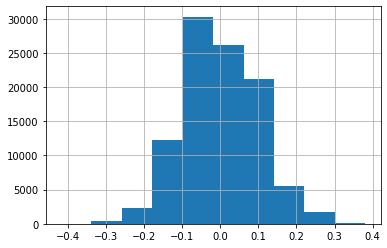

In [409]:
#histograma dos residuos
df_result.Residuo.hist()

<AxesSubplot:xlabel='Previsto', ylabel='Residuo'>

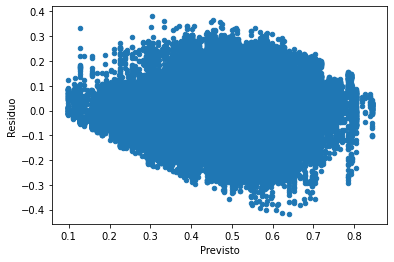

In [410]:
#Residuo vs fitted
df_result.plot(kind='scatter', y='Residuo', x='Previsto')

O gradiente boosting apresentou resultados consideravelmente melhores que a regressao linear e sera utilizado para previsao das taxas de contaminacao.

Podemos utilizar o feature importances para determinar quais politicas de saude deverao ser priorizadas e utilizamos os coeficientes do lasso para entender se a variavel atua positivamente ou negativamente sobre a taxa de transmissao.

# Sugestoes Politicas

In [411]:
coeficientes.head()

,var,coef
0,idade_V1,-0.024504
2,estuda_V1,0.030840
3,pratica_esportes_V1,0.110566
11,transporte_V1_publico,0.017752
12,transporte_V1_taxi,-0.039395


In [412]:
importances = pd.DataFrame({'variavel': vars_selected_manual, 'importances' : modelo.feature_importances_})

In [413]:
importances = importances.merge(coeficientes, how = 'inner', left_on = 'variavel', right_on = 'var')

In [414]:
importances[['variavel','importances','coef']].sort_values(by='importances', ascending = False).rename(columns = {'coef':'coef_lasso'})

,variavel,importances,coef_lasso
3,transporte_V1_publico,0.192293,1.775163e-02
15,gp_familia_visita_rara,0.186143,-1.627727e-01
2,pratica_esportes_V1,0.138089,1.105659e-01
8,trasnporte_V2_particular,0.109692,7.456570e-02
13,gp_familia_visita_casual,0.097517,8.662029e-02
12,gp_familia_mora_junto,0.047636,-6.334766e-02
7,estado_civil_V1_viuvo,0.046633,-9.238012e-02
14,gp_familia_visita_frequente,0.041170,-9.891692e-02
6,estado_civil_V1_solteiro,0.037710,-1.664055e-02
4,transporte_V1_taxi,0.020669,-3.939510e-02


# Prevendo para o restante da populacao

In [415]:
#x contendo todas as variaveis e excluindo as dummies redundantes (estado_civil_solteiro, tranporte_publico e visita rara)
X_to_predict = df_to_predict.filter(vars_selected_manual).values

previsoes =  modelo.predict(X_to_predict)

#adiciona previsoes no data frame a ser previsto e salva csv
conexoes_to_predict = conexoes[conexoes['prob_V1_V2'].isnull()]

conexoes_to_predict['PROB_PREVISTO'] = previsoes

C:\Users\stefanno.ruiz.manni\Anaconda3\envs\neoway\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [416]:
conexoes_to_predict.head()

,V1,V2,grau,proximidade,prob_V1_V2,PROB_PREVISTO
2,2,4,trabalho,visita_casual,NaN,0.522060
4,3,6,amigos,mora_junto,NaN,0.382076
6,4,8,familia,mora_junto,NaN,0.266457
9,5,11,trabalho,visita_casual,NaN,0.553215
10,6,12,familia,visita_casual,NaN,0.525948


In [417]:
#salva em csv
conexoes_to_predict.to_csv('previsoes_tx_contaminacao.csv')

In [418]:
conexoes_to_predict.PROB_PREVISTO.mean()

0.4847696117772584